In [49]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from sklearn.cluster import KMeans
from scipy.ndimage.morphology import binary_fill_holes
import cv2                         
import sys                         
import tqdm                        
import seaborn as sns               
from skimage.morphology import label
import matplotlib.cm as cm  
import glob
from os.path import join
%matplotlib inline 

In [30]:
TRAIN_PATH = 'Retinal/train'
TEST_PATH = 'Retinal/test' 

In [34]:
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)
test_ids

['images', 'mask']

In [35]:
test_image_paths = [glob.glob(join(TEST_PATH, test_id, "*"))[0] for test_id in test_ids]

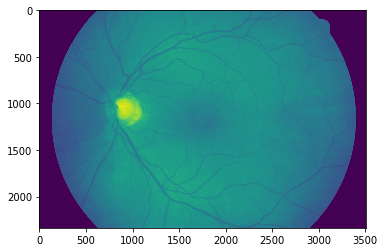

In [37]:
tmp_image_path = np.random.choice(test_image_paths)
tmp_image = cv2.imread(tmp_image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(tmp_image)

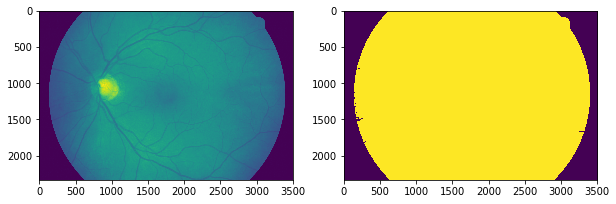

In [39]:
ret, thresh = cv2.threshold(tmp_image, 100, 255, cv2.THRESH_OTSU)
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(tmp_image)
axs[1].imshow(thresh)

In [44]:
cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
max_cnt_area = cv2.contourArea(cnts[0])
print("The area of the largest object is: {0}".format(max_cnt_area))

if max_cnt_area > 50000:
    ret, thresh = cv2.threshold(tmp_image, 100, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

The area of the largest object is: 6896557.5


In [45]:
mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))

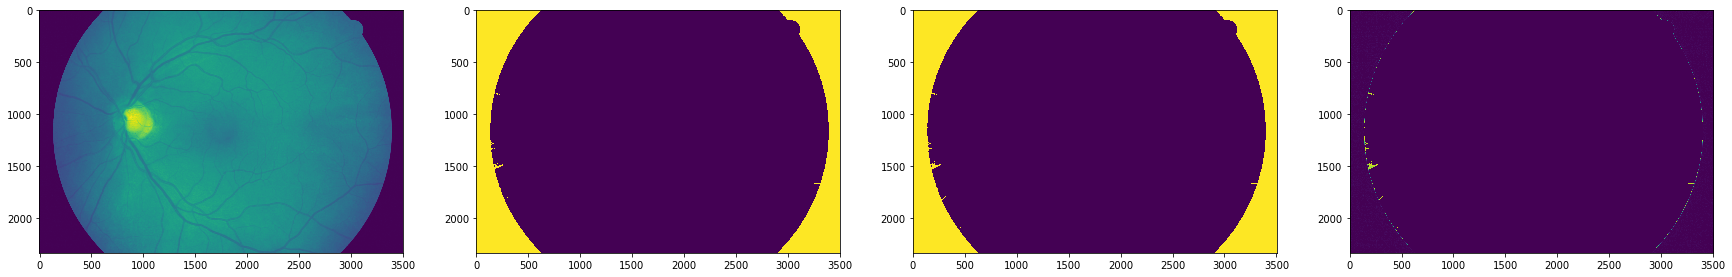

In [46]:
fig, axs = plt.subplots(1, 4, figsize=(30,30))
axs[0].imshow(tmp_image)
axs[1].imshow(thresh)
axs[2].imshow(mask)
axs[3].imshow(cv2.bitwise_and(tmp_image, tmp_image, mask=mask))

In [52]:
def threshold(image_gray):
    image_gray = cv2.GaussianBlur(image_gray, (7, 7), 1)
    ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    max_cnt_area = cv2.contourArea(cnts[0])
    
    if max_cnt_area > 50000:
        ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU 
                                    | cv2.THRESH_BINARY_INV)
    
    return thresh

def apply_morphology(thresh):
    mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    return mask

In [53]:
segmented = []
for test_image_path in test_image_paths:
    tmp_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)    
    thresh = threshold(tmp_image)
    mask = apply_morphology(thresh)    
    segmented.append(mask)


In [54]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)


In [55]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(segmented[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [56]:
submission_df = pd.DataFrame()
submission_df['ImageId'] = new_test_ids
submission_df['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

In [57]:
submission_df.sample(3)

,ImageId,EncodedPixels
57,mask,2104238 2 2106574 4 2108910 5 2111247 4 211358...
9,images,377382 2 379717 3 382052 4 384388 4 386725 3 3...
47,mask,6474277 3 6476612 5 6478947 7 6481283 8 648361...


In [58]:
if not len(np.unique(submission_df["ImageId"])) == len(test_ids):
    print("Submission is not complete")
    print("Missing test ids: {0}".format(set(test_ids).difference(set(np.unique(submission_df["ImageId"])))))
else:
    print("Submission is complete")


Submission is complete
